In [1]:
import os

import nibabel as nib
import scipy.ndimage as ndi
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from sklearn.preprocessing import minmax_scale
import random
import image_augmentation_util
from tqdm import tqdm
import concurrent
import numpy as np

In [2]:
source_data_dir = "../assets/source_images"
source_mask_dir = "../assets/source_image_masks"
output_train_dir = "../assets/test_train_images/train"
output_val_dir = "../assets/test_train_images/val"
output_test_dir = "../assets/test_train_images/test"

In [3]:
images = os.listdir(source_data_dir)
print(len(images))

359


In [4]:
images[10]

'CC0011_philips_15_49_F.nii'

In [5]:
# setting seed for reproduction

random.seed(0)

In [6]:
def inverse_contrast(image, mask):
    mask = mask.astype(bool)

    max_intensity = np.max(image[mask])

    inversed_image = image.copy()
    inversed_image[mask] = max_intensity - image[mask]

    return inversed_image

In [7]:
def read_3d_image(source_dir):
    three_d_image = nib.load(source_dir)
    
    return three_d_image

In [8]:
def scale_image_0_to_255(image):
    scaled_image = minmax_scale(image.ravel(), feature_range=(0,255)).reshape(image.shape)

    return scaled_image

In [9]:
def save_slice_from_3d_data(source_dir, source_mask_dir, min_slice_index, max_slice_index, number_of_slices, output_dir, output_filename, max_height, max_width):
    slice_indices = random.sample(range(min_slice_index, max_slice_index), number_of_slices)

    # read image and mask
    three_d_image = read_3d_image(source_dir)
    three_d_image_data = three_d_image.get_fdata()

    three_d_image_mask = read_3d_image(source_mask_dir)
    three_d_image_mask_data = three_d_image_mask.get_fdata()

    inverse_contrast_image = inverse_contrast(three_d_image_data, three_d_image_mask_data)

    for slice_index in slice_indices:
        # get the ground truth image
        gt_image_slice = inverse_contrast_image[:, :, slice_index].copy()
        gt_image_slice = ndi.rotate(gt_image_slice, 90)
        gt_image_slice = image_augmentation_util.pad_image(gt_image_slice, max_height, max_width)
        gt_output_path = os.path.join(output_dir, "gt", str(slice_index) + "_" + output_filename)

        # get the augmented image
        augmented_image_slice = image_augmentation_util.augment_image(inverse_contrast_image, max_height=max_height, max_width=max_width, thresh_translation=10, thresh_rotation_angle=5, slice_number=slice_index)
        augmented_data_output_path = os.path.join(output_dir, "data", str(slice_index) + "_" + output_filename)

        # scale both images 0-255
        gt_image_slice = scale_image_0_to_255(gt_image_slice)
        augmented_image_slice = scale_image_0_to_255(augmented_image_slice)

        # save images to directory
        gt_image_slice_pil = Image.fromarray(gt_image_slice)
        gt_image_slice_pil = gt_image_slice_pil.convert("L")
        print(f"Saving to {gt_output_path}")
        gt_image_slice_pil.save(gt_output_path)

        augmented_image_slice_pil = Image.fromarray(augmented_image_slice)
        augmented_image_slice_pil = augmented_image_slice_pil.convert("L")
        print(f"Saving to {augmented_data_output_path}")
        augmented_image_slice_pil.save(augmented_data_output_path)


In [10]:
slice_limit_dict = {
    "philips_min": 145,
    "philips_max": 190,
    "siemens_min": 140,
    "siemens_max": 172,
    "ge_min": 155,
    "ge_max": 195
}

In [11]:
def get_min_max_slice_indices(file_name):
    if "philips" in file_name:
        return slice_limit_dict["philips_min"], slice_limit_dict["philips_max"]
    
    elif "siemens" in file_name:
        return slice_limit_dict["siemens_min"], slice_limit_dict["siemens_max"]
    
    else:
        return slice_limit_dict["ge_min"], slice_limit_dict["ge_max"]

In [12]:
number_of_slices = 30

In [13]:
thread_pool = concurrent.futures.ThreadPoolExecutor()

In [14]:
random.shuffle(images)

train_split = 0.70
val_split = 0.14
test_split = 1 - (train_split + val_split)

train_images = images[:int(len(images) * train_split)]
val_images = images[int(len(images) * train_split) : int(len(images) * (train_split + val_split))]
test_images = images[int(len(images) * (train_split + val_split)):]

print(len(train_images))
print(len(val_images))
print(len(test_images))

print("Processing train images")

for image in tqdm(train_images):
    if image.endswith("DS_Store"):
        continue
    
    mask_filename = image.split(".")[0] + "_staple" + ".nii"
    output_filename = image.split(".")[0] + ".jpg"

    min_slice_index, max_slice_index = get_min_max_slice_indices(image)

    # save the augmented data in "data" dir
    thread_pool.submit(save_slice_from_3d_data, os.path.join(source_data_dir, image), os.path.join(source_mask_dir, mask_filename), min_slice_index, max_slice_index, number_of_slices, output_train_dir, output_filename, 288, 256)


print("Processing validation images")

for image in tqdm(val_images):
    if image.endswith("DS_Store"):
        continue
    
    mask_filename = image.split(".")[0] + "_staple" + ".nii"
    output_filename = image.split(".")[0] + ".jpg"

    min_slice_index, max_slice_index = get_min_max_slice_indices(image)

    # save the augmented data in "data" dir
    thread_pool.submit(save_slice_from_3d_data, os.path.join(source_data_dir, image), os.path.join(source_mask_dir, mask_filename), min_slice_index, max_slice_index, number_of_slices, output_val_dir, output_filename, 288, 256)

print("Processing test images")

for image in tqdm(test_images):
    if image.endswith("DS_Store"):
        continue
    
    mask_filename = image.split(".")[0] + "_staple" + ".nii"
    output_filename = image.split(".")[0] + ".jpg"

    min_slice_index, max_slice_index = get_min_max_slice_indices(image)

    # save the augmented data in "data" dir
    thread_pool.submit(save_slice_from_3d_data, os.path.join(source_data_dir, image), os.path.join(source_mask_dir, mask_filename), min_slice_index, max_slice_index, number_of_slices, output_test_dir, output_filename, 288, 256)

thread_pool.shutdown(wait=True)

251
50
58
Processing train images


100%|██████████| 251/251 [00:00<00:00, 3058.73it/s]


Processing validation images


100%|██████████| 50/50 [00:00<00:00, 24989.90it/s]


Processing test images


100%|██████████| 58/58 [00:00<00:00, 28977.92it/s]


Translated for 9 pixels
Translated for 3 pixels
Translated for -4 pixels
Translated for 8 pixels
Translated for -10 pixels
Translated for -9 pixels
Translated for -3 pixels
Translated for 4 pixels
Translated for 0 pixels
Translated for -6 pixels
Translated for -7 pixels
Translated for -1 pixels
Translated for -8 pixels
Translated for 9 pixels
Translated for -5 pixels
Translated for -4 pixels
Translated for -6 pixels
Translated for 2 pixels
Translated for -7 pixels
Translated for -2 pixels
Rotated 3.812033386179305 degrees in x axis
Rotated 0.4959241296576895 degrees in y axis
Rotated 2.9974359488451983 degrees in z axis
Translated for -1 pixels
Rotated 0.6753316274916008 degrees in x axis
Rotated 1.4823152254698613 degrees in y axis
Rotated -4.565793267192787 degrees in z axis
Rotated -0.9221509147712297 degrees in x axis
Rotated -3.4844966718591164 degrees in y axis
Rotated -4.706362808503512 degrees in z axis
Translated for -1 pixels
Rotated -0.3843796661872654 degrees in x axis
Rota

In [ ]:
sample_image = read_3d_image(os.path.join(source_data_dir, images[0]))

In [ ]:
sample_image = sample_image.get_fdata()
sample_image = ndi.rotate(sample_image[:, :, 160], 90)

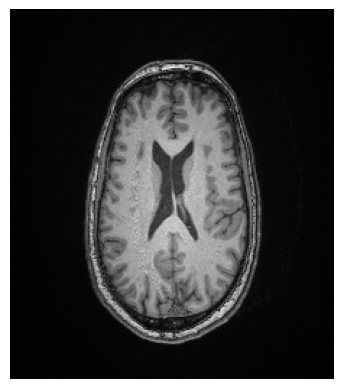

In [ ]:
plt.imshow(sample_image, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
sample_image_pil = Image.fromarray(sample_image)
sample_image_pil = sample_image_pil.convert('L')
sample_image_pil.save("test_image_slice.jpg")

In [ ]:
cv2.imwrite("test_image_slice_cv.jpg", sample_image)

True

In [ ]:
# shape = sample_image.shape

image_scaled = minmax_scale(sample_image.ravel(), feature_range=(0,255)).reshape(sample_image.shape)

In [ ]:
cv2.imwrite("test_image_slice_cv_scaled.jpg", image_scaled)

True